In [1]:
from src.kernel.timeline import Timeline
from src.components.optical_channel import ClassicalChannel, QuantumChannel
from src.kernel.event import Event
from src.kernel.process import Process
from src.topology.node import raman_receiver_node, raman_sender_node
from src.entanglement_management.raman_protocols import RamanTestReceiver
from matplotlib import pyplot as plt
import traceback
import numpy as np
import os

In [2]:
def init_experiment_setup(params):
    sender = raman_sender_node("sender", params["tl"], params["num_iterations"], params["clock_power"], params["narrow_band_filter_bandwidth"], params["quantum_channel_wavelength"], 
                               params["mean_photon_num"], params["is_distinguishable"], params["pulse_separation"], params["batch_size"], params["pulse_width"])
    signal_receiver = raman_receiver_node("signal_receiver", params["tl"], 'sender', params["collection_probability"], params["dark_count_rate"], params["dead_time"], params["time_resolution"])
    idler_receiver = raman_receiver_node("idler_receiver", params["tl"], 'sender', params["collection_probability"], params["dark_count_rate"], params["dead_time"], params["time_resolution"])

    receiver_protocol = RamanTestReceiver(signal_receiver, idler_receiver, 'sender', params["pulse_separation"])

    signal_receiver.attach_detector_to_receiver(receiver_protocol)
    idler_receiver.attach_detector_to_receiver(receiver_protocol)
    sender.attach_lightsource_to_receivers("signal_receiver", "idler_receiver")


    signal_channel = QuantumChannel("signal_channel", params["tl"], params["quantum_channel_attenuation"], params["classical_channel_attenuation"], params["distance"], params["raman_coefficient"], 
                                    params["polarization_fidelity"], params["light_speed"], params["max_rate"], params["quantum_channel_wavelength"], params["classical_channel_wavelength"])
    idler_channel = QuantumChannel("idler_channel", params["tl"], params["quantum_channel_attenuation"], params["classical_channel_attenuation"], params["distance"], params["raman_coefficient"], 
                                    params["polarization_fidelity"], params["light_speed"], params["max_rate"], params["quantum_channel_wavelength"], params["classical_channel_wavelength"])
    classical_channel = ClassicalChannel("classical_channel", params["tl"], params["distance"])
    signal_channel.set_ends(sender, "signal_receiver")
    idler_channel.set_ends(sender, "idler_receiver")
    classical_channel.set_ends(sender, "signal_receiver")

    return sender

In [3]:
experimental_parameters = {
    "tl" : Timeline(5000e12),

    # Parameters
    # Detector_parameters
    "collection_probability" : 10**(-1.2),
    "dark_count_rate" : 100, #100,
    "dead_time" : 25000,
    "time_resolution" : 50,

    # Optical channel
    "quantum_channel_attenuation" : 0.44,
    "classical_channel_attenuation" : 0.5,
    "distance" : 2,
    "raman_coefficient" : 33e-10,
    "polarization_fidelity" : 1,
    "light_speed" : 3e8,
    "max_rate" : 1e12,
    "quantum_channel_wavelength" : 1536e-9,
    "classical_channel_wavelength" : 1610e-9,

    # Light Source
    # "wavelength" : quantum_channel_wavelength,
    "mean_photon_num" : 0.00316228, # 0.01
    "is_distinguishable" : True,
    "pulse_separation" : 5e3,
    "pulse_width" : 80,
    "batch_size" : 50000000,
    "num_iterations" : 100, # 240, 600,

    # Clock parameters
    "clock_power" : 0.0003,
    "narrow_band_filter_bandwidth" : 0.03,
}

try:
    experimental_parameters["tl"] = Timeline(5000e12)
    # experimental_parameters["mean_photon_num"] = 0.01
    sender = init_experiment_setup(experimental_parameters)
    process = Process(sender.protocol, "start", [])
    event = Event(0, process)
    experimental_parameters["tl"].schedule(event)

    experimental_parameters["tl"].init()
    experimental_parameters["tl"].run()
    #     file = open("CAR_Data.txt")
    #     CAR_Data.append(list(map(float, file.readlines())))
    #     file.close()
    #     os.remove("CAR_Data.txt")
    # plt.boxplot(list(zip(*CAR_Data)))
    # plt.xticks(np.arange(num_samples)+1, np.logspace(min_mpn, max_mpn, num_samples))

        

    # print(signal_receiver.protocol.coincidence_times)
    
    # n, bins, patches = plt.hist(signal_receiver.protocol.detection_times, range(-28125, 28126, 6250))
    # plt.show()    
except Exception:
    print(traceback.format_exc())

I,j: -1.2 0
last emit time: 25400000502920.0
Raman photosns added 45567
pulse window ID 0
Raman photosns added 45567
pulse window ID 1
Raman photosns added 45567
pulse window ID 2
Raman photosns added 45567
pulse window ID 3
Raman photosns added 45567
pulse window ID 4
Raman photosns added 45567
pulse window ID 5
Raman photosns added 45567
pulse window ID 6
Raman photosns added 45567
pulse window ID 7
Raman photosns added 45567
pulse window ID 8
Raman photosns added 45567
pulse window ID 9
Raman photosns added 45567
pulse window ID 10
Raman photosns added 45567
pulse window ID 11
Raman photosns added 45567
pulse window ID 12
Raman photosns added 45567
pulse window ID 13
Raman photosns added 45567
pulse window ID 14
Raman photosns added 45567
pulse window ID 15
Raman photosns added 45567
pulse window ID 16
Raman photosns added 45567
pulse window ID 17
Raman photosns added 45567
pulse window ID 18
Raman photosns added 45567
pulse window ID 19
Raman photosns added 45567
pulse window ID 20

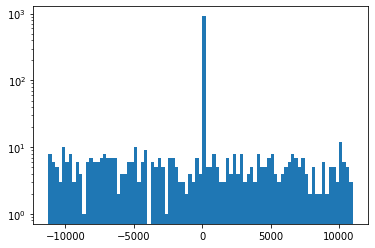

I,j: -1.35 0
last emit time: 25400000502920.0
Raman photosns added 45567
pulse window ID 0
Raman photosns added 45567
pulse window ID 1
Raman photosns added 45567
pulse window ID 2
Raman photosns added 45567
pulse window ID 3
Raman photosns added 45567
pulse window ID 4
Raman photosns added 45567
pulse window ID 5
Raman photosns added 45567
pulse window ID 6
Raman photosns added 45567
pulse window ID 7
Raman photosns added 45567
pulse window ID 8
Raman photosns added 45567
pulse window ID 9
Raman photosns added 45567
pulse window ID 10
Raman photosns added 45567
pulse window ID 11
Raman photosns added 45567
pulse window ID 12
Raman photosns added 45567
pulse window ID 13
Raman photosns added 45567
pulse window ID 14
Raman photosns added 45567
pulse window ID 15
Raman photosns added 45567
pulse window ID 16
Raman photosns added 45567
pulse window ID 17
Raman photosns added 45567
pulse window ID 18
Raman photosns added 45567
pulse window ID 19
Raman photosns added 45567
pulse window ID 2

In [4]:
try:
    CAR_Data = []
    for j in range(1):
        for i in np.linspace(-1.2,-1.8,5):
            print("I,j:", i, j)
            experimental_parameters["tl"] = Timeline(5000e12)
            experimental_parameters["collection_probability"] = 10**i
            sender = init_experiment_setup(experimental_parameters)
            process = Process(sender.protocol, "start", [])
            event = Event(0, process)
            experimental_parameters["tl"].schedule(event)

            experimental_parameters["tl"].init()
            experimental_parameters["tl"].run()
        file = open("CAR_Data.txt")
        CAR_Data.append(list(map(float, file.readlines())))
        file.close()
   
except Exception:
    print(traceback.format_exc())

len of temp_data: 15
[[91.33333333333333, 75.08196721311475, 45.38775510204081, 29.6, 17.125], [98.29213483146067, 66.0, 50.095238095238095, 26.358974358974358, 21.0], [106.53658536585365, 69.86666666666666, 46.04081632653061, 25.363636363636363, 12.8]]


C:\Users\anshs\AppData\Local\Temp/ipykernel_17500/3415327383.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


{'whiskers': [<matplotlib.lines.Line2D at 0x1b8a770ae20>,
 'caps': [<matplotlib.lines.Line2D at 0x1b8aeb85850>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b8b13ba310>,
 'medians': [<matplotlib.lines.Line2D at 0x1b8b0fec970>,
 'fliers': [<matplotlib.lines.Line2D at 0x1b8ab441160>,
 'means': [<matplotlib.lines.Line2D at 0x1b8a770a9a0>,
  <matplotlib.lines.Line2D at 0x1b8b1376be0>]}

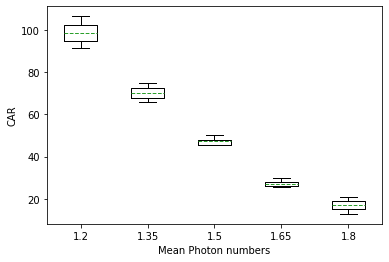

In [8]:
CAR_Data = []
temp_data = []
file = open("CAR_Data.txt")
temp_data.append(list(map(float, file.readlines())))
file.close()

print("len of temp_data:", len(temp_data[0]))

for i in range(3):
    CAR_Data.append(temp_data[0][i*5:(i+1)*5])

print(CAR_Data)

fig, ax = plt.subplots()
fig.canvas.draw()
labels = [str(i)[1:6] for i in np.linspace(-1.2,-1.8,5)]# [0.000562341,0.001,0.001778279,0.00316228,0.00562341,0.01,0.01778279,0.03162278,0.05623413,0.1]]
ax.set_xticklabels(labels)
ax.set_xlabel("Mean Photon numbers")
ax.set_ylabel("CAR")
plt.boxplot(list(zip(*CAR_Data)), meanline = True, showmeans=True, medianprops={"linewidth":0})